## Music League Stats

All of the data is scraped into a pandas dataframe with each row 

In [5]:
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm


from scraper import translator, create_dataframe
from spotify_data import get_spotify_data, get_playlist, playlists

In [6]:
path = Path("../music_league/")

df, names = create_dataframe(path=path, translator=translator)
df = get_spotify_data(music_league_df=df)

In [7]:
round_names = (
    "generation game",
    "remix",
    "songs to code to",
    "ich spreche kein englisch",
    "wish you were here",
    "film soundtrack",
    "yesteryear",
    "120 seconds to go",
    "cover",
    "eurovision"
)

## Voting Matrix

In [8]:
winning_order = df.groupby(df["submitter"])[names].sum().sum(axis=1)
winning_order = winning_order.sort_values(ascending=False).index


arr = np.concatenate([
        group.reindex(winning_order, fill_value=0.0).to_numpy()[None, :, :]
        for _, group in df.set_index(df["submitter"]).groupby("round")[winning_order]], axis=0)
correlation = np.sum(arr, axis=0)

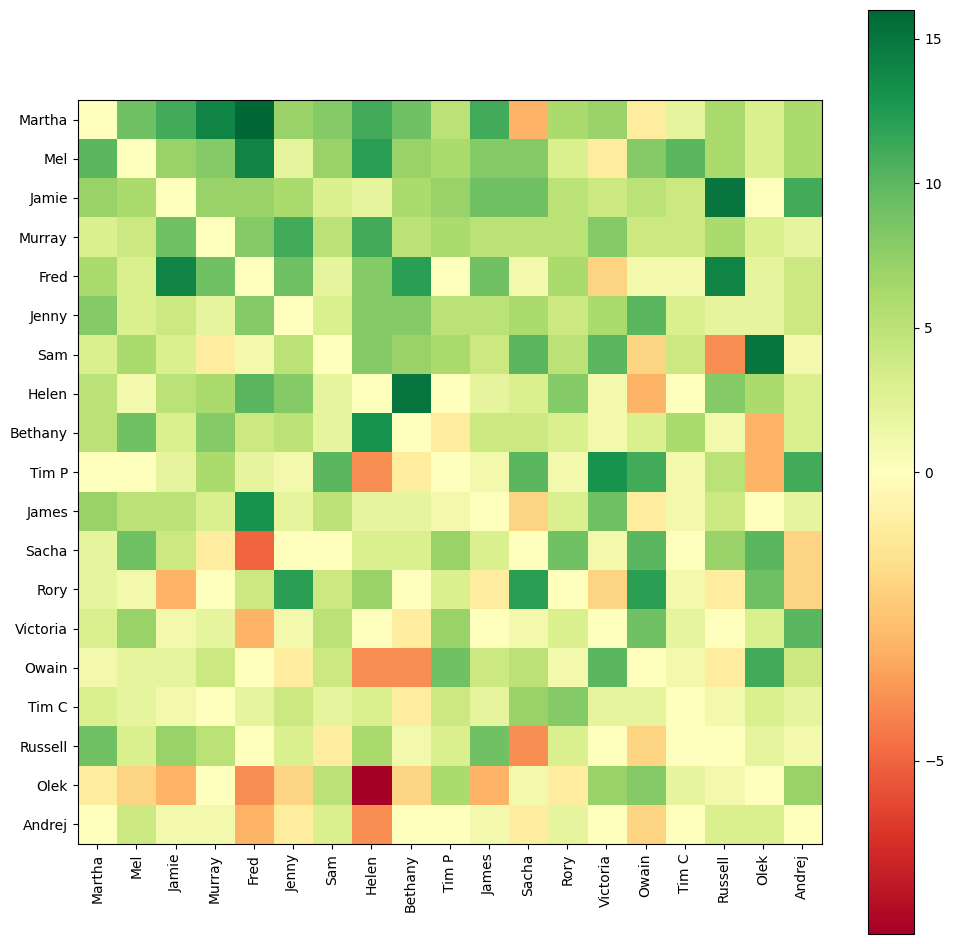

In [9]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(correlation),
                        vcenter=0,
                        vmax=np.max(correlation))

plt.imshow(correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)


cbar = plt.colorbar()

plt.show()

In [10]:
biggest_stans = np.unravel_index(np.argsort(-correlation.reshape(-1))[:10], correlation.shape)
for row, col in zip(*biggest_stans):
    print(f"{winning_order[col]} for {winning_order[row]}: {correlation[row, col]}")


Fred for Martha: 16.0
Bethany for Helen: 15.0
Russell for Jamie: 15.0
Olek for Sam: 15.0
Jamie for Fred: 14.0
Russell for Fred: 14.0
Fred for Mel: 14.0
Murray for Martha: 14.0
Victoria for Tim P: 13.0
Fred for James: 13.0


In [11]:
biggest_haters = np.unravel_index(np.argsort(correlation.reshape(-1))[:10], correlation.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {correlation[row, col]}")


Helen for Olek: -8.0
Fred for Sacha: -5.0
Russell for Sam: -4.0
Fred for Olek: -4.0
Sacha for Russell: -4.0
Bethany for Owain: -4.0
Helen for Andrej: -4.0
Helen for Tim P: -4.0
Helen for Owain: -4.0
Fred for Victoria: -3.0


In [12]:
df["round_score"] = df[winning_order].sum(axis=1)

# Round winners

for round_name, (round, scores) in zip(round_names, df.groupby("round")):
    winning_score = scores["round_score"].max()
    a = f"Round {round} | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "track_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['track_name']:40} | {int(row['round_score'])}")
    print()


Round 1 | generation game
-------------------------
Sacha      | Message In A Bottle                      | 16
Bethany    | Gypsy Woman (La Da Dee La Da Da)         | 16

Round 2 | remix
---------------
Murray     | 19-2000 - Soulchild Remix                | 19
Martha     | Flowers - Sunship Remix                  | 19

Round 3 | songs to code to
--------------------------
Jenny      | Song of Storms                           | 18

Round 4 | ich spreche kein englisch
-----------------------------------
Murray     | Mundian to Bach Ke                       | 29

Round 5 | wish you were here
----------------------------
Mel        | London Calling - Remastered              | 19

Round 6 | film soundtrack
-------------------------
Jamie      | Lose Yourself                            | 23

Round 7 | yesteryear
--------------------
Jamie      | Nothing Matters                          | 15

Round 8 | 120 seconds to go
---------------------------
Mel        | Fell In Love With a Girl       

In [13]:
df.sort_values("round_score", ascending=False).iloc[:10][["submitter", "track_name", "round_score"]]

,submitter,track_name,round_score
74,Murray,Mundian to Bach Ke,29.0
168,Jamie,Hurt,23.0
112,Jamie,Lose Yourself,23.0
113,Martha,9 to 5,21.0
149,Mel,Fell In Love With a Girl,21.0
19,Rory,SHUM,20.0
38,Murray,19-2000 - Soulchild Remix,19.0
39,Martha,Flowers - Sunship Remix,19.0
93,Mel,London Calling - Remastered,19.0
56,Jenny,Song of Storms,18.0


In [14]:
df.sort_values("round_score", ascending=True).iloc[:10][["submitter", "track_name", "round_score"]]

,submitter,track_name,round_score
167,Andrej,Baby Shark,-17.0
129,Olek,Waters of Nazareth x We Are your Friends x Pha...,-13.0
186,James,Bohemian Rhapsody,-11.0
37,Russell,Congratulations,-10.0
92,Andrej,Dragostea Din Tei,-10.0
185,Sacha,Painkiller,-7.0
128,Andrej,"Come What May - From ""Moulin Rouge"" Soundtrack",-5.0
91,Tim P,Tequila,-5.0
110,Bethany,Atlantic City,-5.0
73,Olek,Final - Live Version - Rappel,-5.0


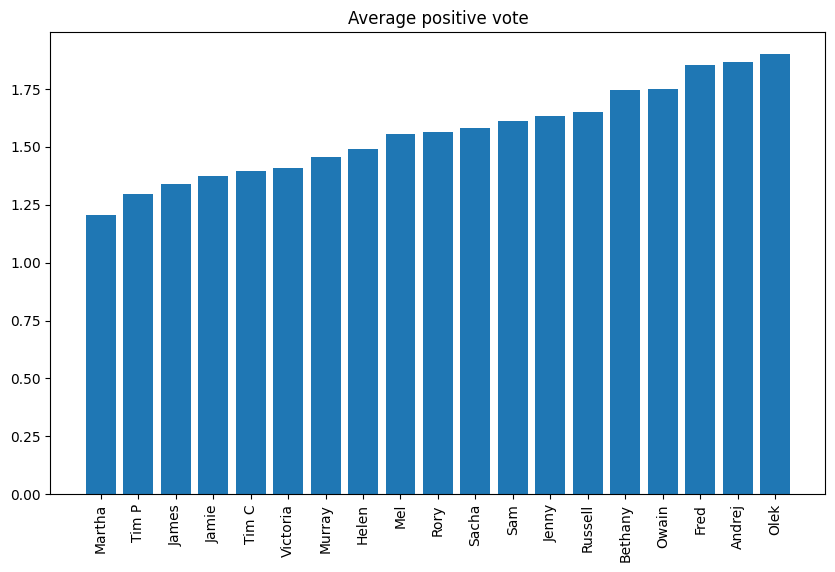

In [15]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

In [16]:
df["song_age_seconds"] = (datetime.now() - df["date"]).dt.total_seconds()

In [17]:
# Average song age

df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

submitter
Victoria   2017-06-01 12:00:00.011128
Rory       2016-05-26 07:12:00.012129
Owain      2015-03-18 14:24:00.012129
Olek       2013-07-03 00:00:00.012129
Sam        2012-07-15 04:48:00.012129
Murray     2012-03-01 07:12:00.012129
Andrej     2010-06-12 00:00:00.012129
Tim P      2007-01-22 12:00:00.012129
Jenny      2006-05-20 00:00:00.012129
Helen      2006-05-14 16:48:00.012129
Bethany    2006-04-13 16:00:00.012129
Tim C      2005-04-27 15:00:00.012129
Mel        2004-10-30 09:36:00.012129
Sacha      2002-02-24 16:48:00.012129
Martha     2001-09-21 16:48:00.012129
Jamie      2001-07-10 07:12:00.012129
Russell    2000-02-20 07:12:00.012129
James      1998-11-06 14:24:00.012129
Fred       1993-08-02 02:24:00.012129
Name: song_age_seconds, dtype: datetime64[ns]

In [18]:
# song length

df[df["round"] != 8].groupby("submitter")["duration"].sum()

submitter
Andrej      1848.219
Bethany     1723.012
Fred        2146.785
Helen       2266.625
James       2915.843
Jamie       2389.655
Jenny       1890.889
Martha      2137.663
Mel         1868.776
Murray      2037.116
Olek        2260.932
Owain       1887.041
Rory        2030.768
Russell     2825.664
Sacha       2442.544
Sam         1832.054
Tim C       1694.391
Tim P       1813.080
Victoria    1775.183
Name: duration, dtype: float64

In [19]:
df.sort_values("duration", ascending=False)[["submitter", "track_name", "duration"]].iloc[:10]

,submitter,track_name,duration
68,Russell,Blue Room,1053.813
70,James,Never Gonna Reach Me - Hot Toddy Remix,580.363
61,Sacha,Exercises in Futility V,495.626
48,Jamie,"Girls & Boys - Pet Shop Boys Remix, 2012 Remaster",436.546
18,Tim C,Seek & Destroy - Remastered,414.720
45,James,"Relight My Fire - 12"" Disco Remix",406.213
129,Olek,Waters of Nazareth x We Are your Friends x Pha...,391.782
42,Helen,Heads Will Roll - A-Trak Remix,383.893
176,Murray,War Pigs,379.647
136,James,Satisfy My Soul,362.956


In [20]:
df[df["round"]!=8].sort_values("duration")[["submitter", "track_name", "duration"]].iloc[:10]

,submitter,track_name,duration
72,Victoria,Baby Park,55.500
34,Sam,Bono's a Fucking Cunt,95.506
88,Sacha,Policia - 2017 Remaster,106.866
131,Bethany,Speed Drive (From Barbie The Album),117.809
84,Bethany,Laisse Tomber Les Filles,125.933
67,Sam,Screaming Man - Sound Effect,133.355
91,Tim P,Tequila,135.240
89,Tim C,Die Eier von Satan,137.360
132,Andrej,My Love Mine All Mine,137.773
123,Owain,"Comptine d'un autre été, l'après-midi",140.733


In [21]:
# Energy

df.groupby("submitter")["energy"].mean().sort_values(ascending=False)

submitter
Sacha       0.893900
Rory        0.863600
Murray      0.788190
Mel         0.768800
Sam         0.767300
Tim C       0.765429
Jenny       0.758900
Helen       0.748000
Tim P       0.738600
Bethany     0.736333
Owain       0.732200
Russell     0.719800
Jamie       0.692300
Victoria    0.692000
James       0.661500
Olek        0.656600
Fred        0.626700
Martha      0.619100
Andrej      0.509002
Name: energy, dtype: float64

In [22]:
df.sort_values("energy", ascending=False)[["submitter", "track_name", "energy"]].iloc[:10]

,submitter,track_name,energy
73,Olek,Final - Live Version - Rappel,0.996
185,Sacha,Painkiller,0.995
12,Rory,(sic),0.994
88,Sacha,Policia - 2017 Remaster,0.991
153,Sam,Freaks to the Front,0.988
72,Victoria,Baby Park,0.982
149,Mel,Fell In Love With a Girl,0.982
47,Sacha,Jesus Built My Hotrod (Powerman 5000 Remix),0.979
17,Owain,輪舞-revolution,0.975
61,Sacha,Exercises in Futility V,0.971


In [23]:
df.sort_values("energy")[["submitter", "track_name", "energy"]].iloc[:10]

,submitter,track_name,energy
69,Andrej,4'33'',0.00002
121,Murray,Concerning Hobbits,0.06290
182,Olek,Creep,0.10800
150,Jamie,Golden Slumbers - Remastered 2009,0.15200
67,Sam,Screaming Man - Sound Effect,0.18200
123,Owain,"Comptine d'un autre été, l'après-midi",0.19200
60,Tim P,Vision On,0.19400
163,Fred,Cripple Creek Ferry,0.22200
5,Andrej,Dub Be Good To Me,0.27200
169,Bethany,Killing Me Softly With His Song,0.28900


In [24]:
df.sort_values("danceability", ascending=False)[["submitter", "track_name", "danceability"]].iloc[:10]

,submitter,track_name,danceability
64,Martha,Computer World - 2009 Remaster,0.931
162,Helen,BIZCOCHITO,0.930
9,Mel,Family Affair,0.911
152,Jenny,Old Town Road,0.907
13,Murray,Me Myself and I,0.889
21,Martha,Think About Things,0.872
5,Andrej,Dub Be Good To Me,0.861
11,Helen,Can I Kick It?,0.848
161,Olek,Fly Away,0.846
167,Andrej,Baby Shark,0.829


In [25]:
df.sort_values("danceability")[["submitter", "track_name", "danceability"]].iloc[:10]

,submitter,track_name,danceability
69,Andrej,4'33'',0.173
111,Tim C,Munich,0.184
16,Russell,New Rose,0.191
61,Sacha,Exercises in Futility V,0.194
182,Olek,Creep,0.200
98,Martha,By The Time I Get To Phoenix - Remastered 2001,0.218
108,Jamie,Trains To Brazil,0.256
176,Murray,War Pigs,0.275
128,Andrej,"Come What May - From ""Moulin Rouge"" Soundtrack",0.288
34,Sam,Bono's a Fucking Cunt,0.304


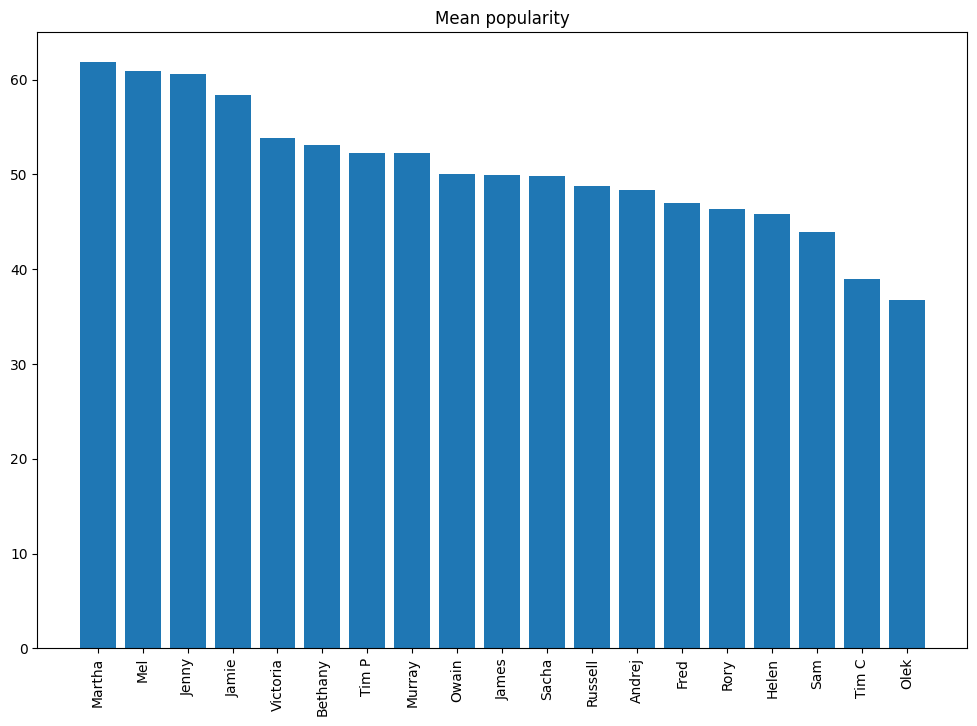

In [26]:
# popularity

fig, ax = plt.subplots(figsize=(12, 8))

pop = df.groupby("submitter")["popularity"].mean().sort_values(ascending=False)
ax.bar(range(len(pop)), pop)
ax.set_xticks(range(len(pop)), pop.index, rotation="vertical")


ax.set_title("Mean popularity")

plt.show()

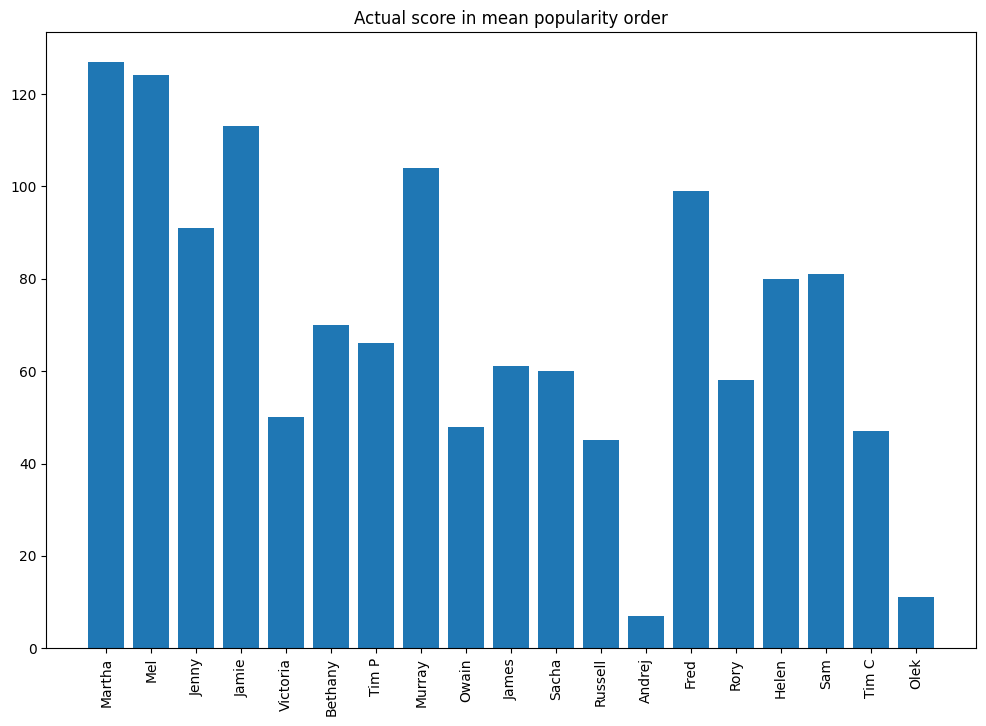

In [27]:
actual = df.groupby("submitter")[winning_order].sum().sum(axis=1).reindex(pop.index)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(range(len(pop)), actual)
ax.set_xticks(range(len(pop)), pop.index, rotation="vertical")


ax.set_title("Actual score in mean popularity order")

plt.show()

In [28]:
playlists = [get_playlist(playlist) for playlist in playlists]

In [61]:
i, a = list(df.groupby("round"))[0]

vals = []

for i, a in df.groupby("round"):
    vals.append(a.sort_values("round_score", ascending=False)["song_id"].map(lambda x: playlists[i-1].index(x)))

vals[0]

0      6
1      1
2      4
3      2
4     11
5      9
6     13
7      7
9     10
8     17
10    18
11    14
12     3
13     5
14    16
15    15
16    12
17     0
18     8
Name: song_id, dtype: int64

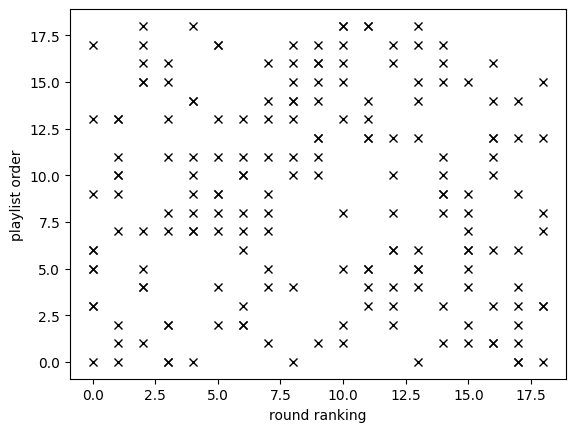

In [70]:
rankings = np.array([i for df in vals for i in range(len(df))])
playlist_order = np.array([i for df in vals for i in df.values])

plt.xlabel("round ranking")
plt.ylabel("playlist order")

plt.plot(rankings, playlist_order, "kx")
plt.show()


In [71]:
np.corrcoef(rankings, playlist_order)

array([[ 1.        , -0.04435978],
       [-0.04435978,  1.        ]])